##### Татур А.А.
##### ver 0.1
##### Дата - 22.10.2022
##### ОПИСАНИЕ
##### модель - RandomForestClassifier. Проведен поиск параметров, выявлены оптимальные. Отдельно тестировались скалированные и нескалированные данные
##### датасет - полный, без удаления выбросов, N/A не удалялись, заполнялись средними (mean()) значениями для количественных
##### и самыми частыми для качественных. N/A в поле 'monthly_income' было заполнено средним по региону, к которому относится 
##### запись
##### 

### Цели:

1. Анализ данных
2. Обработка пропусков и выбросов
3. Поиск корелляций.
4. Тест на нормальность распределения.
5. Масштабировать и стандартизировать данные.
6. Разделите данные на тренрровачную и тестовую выборку.
7. Скалирование тестовой и тренировачную выборки
8. Поиск оптимальных гиперпараметров модели
9. Тренировка моделей на скалированных и нескалированных параметрах
10. Выводы

#### Импорт библиотек

In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import region_cleaner
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import normaltest
from sklearn.model_selection import GridSearchCV
import time
%run ./region_clean_module.ipynb #собственная функция очистки регионов, вынесенная в отдельный файл

#### Чтение данных

In [119]:
df=pd.read_csv('credit_train.csv', 
               encoding='cp1251', 
               sep=';',
               index_col='client_id',
               decimal=",")

#### Создание копии для работы

In [120]:
df_cleaned=df.copy()

#### Обработка данных, заполнение пропусков

In [121]:
#применяем функцию region_clean к регионам, исправляем записи
df_cleaned['living_region']=df['living_region'].apply(region_clean)

In [123]:
#ищем среднюю зарплату по всем регионам
df_mean_salaries=df_cleaned.groupby('living_region', as_index=False)['monthly_income'].mean()

In [124]:
#получаем индексы всех случаев, где пропущена зарплата
list_of_index=df_cleaned['monthly_income'].index[df['monthly_income'].apply(np.isnan)].to_list()

In [125]:
#### Заполняем пропуски по зарплате по среднему из региона, к которому относится пропуск!
for i in list_of_index:
    region_w_NA = df_cleaned.loc[i]['living_region']
    salary = df_mean_salaries.loc[df_mean_salaries['living_region']==region_w_NA]['monthly_income'].item()
    df_cleaned.loc[i,'monthly_income']=int(salary)

In [126]:
#Заполняем пропуски семейного статуса средним значением
df_cleaned['age']=df_cleaned['age'].fillna(df_cleaned['age'].mean())

In [127]:
#Заполняем пропуски семейного статуса самым частым значением
df_cleaned['marital_status']=df_cleaned['marital_status'].fillna('MAR')

In [128]:
#Заполняем пропуски education самым частым значением
df_cleaned['education']=df_cleaned['education'].fillna('SCH')

In [129]:
#Заполняем пропуски кредитной суммы средним значением
df_cleaned['credit_sum']=df_cleaned['credit_sum'].fillna(df_cleaned['credit_sum'].mean())

In [130]:
#Заполняем пропуски score_shk средним значением
df_cleaned['score_shk']=df_cleaned['score_shk'].fillna(df_cleaned['score_shk'].mean())

In [131]:
#Заполняем пропуски score_shk средним значением
df_cleaned['credit_count']=df_cleaned['credit_count'].fillna(df_cleaned['credit_count'].mean())

In [132]:
#Заполняем пропуски score_shk средним значением
df_cleaned['overdue_credit_count']=df_cleaned['overdue_credit_count'].fillna(df_cleaned['overdue_credit_count'].mean())

#### Оценка выбросов количественных параметров

<AxesSubplot:>

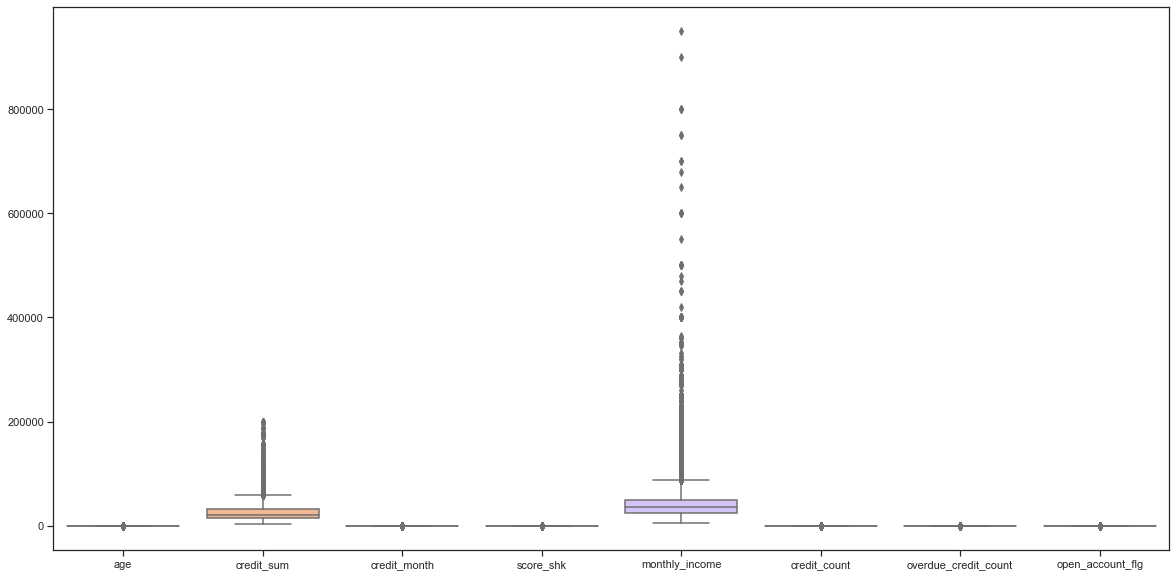

In [133]:
sns.set_theme(style="ticks", palette="pastel")
plt.figure (figsize=(20,10))
sns.boxplot (data=df_cleaned)

##### Поиск корреляций

<AxesSubplot:>

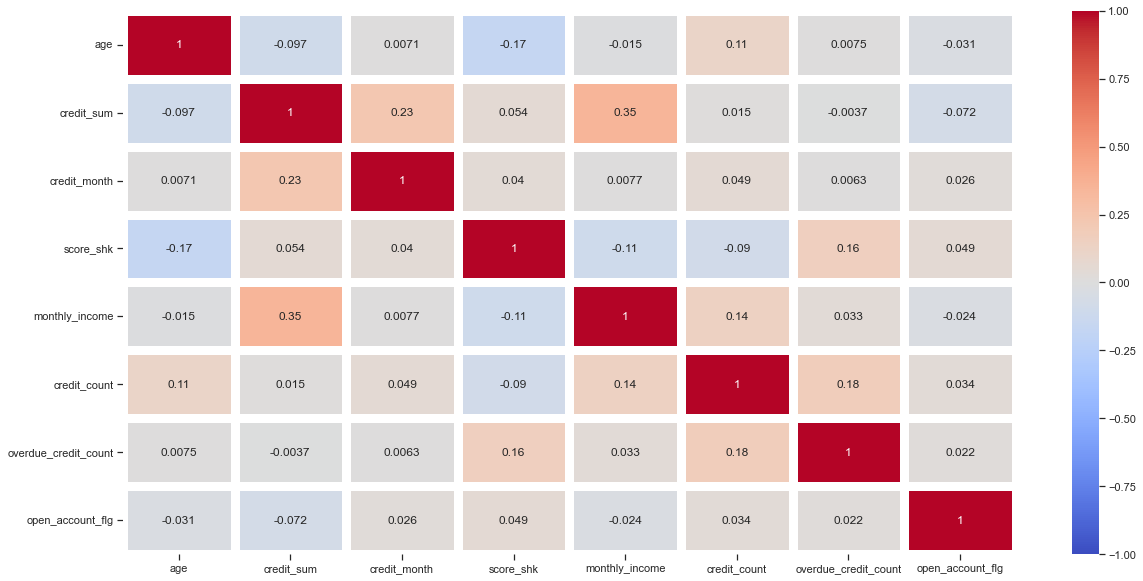

In [39]:
plt.figure(figsize=(20,10))
sns.heatmap(df_cleaned.corr(), annot=True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=9, linecolor='white', cbar_kws= {'orientation': 'vertical'})

#### Проверка на нормальность распределения

In [40]:
numberic_postions = ['age', 'credit_sum', 'credit_month', 'tariff_id', 'score_shk', 'monthly_income', 'credit_count', 
                     'overdue_credit_count','open_account_flg']
for pos in numberic_postions:
    print (pos,end=': ')
    if normaltest(df_cleaned[pos].astype(np.float32).values).pvalue>0.05:
        print ("Распределение СООТВЕТСТВУЕТ нормальному")
    else:
        print ("Распределение НЕ СООТВЕТСТВУЕТ нормальному")

age: Распределение НЕ СООТВЕТСТВУЕТ нормальному
credit_sum: Распределение НЕ СООТВЕТСТВУЕТ нормальному
credit_month: Распределение НЕ СООТВЕТСТВУЕТ нормальному
tariff_id: Распределение НЕ СООТВЕТСТВУЕТ нормальному
score_shk: Распределение НЕ СООТВЕТСТВУЕТ нормальному
monthly_income: Распределение НЕ СООТВЕТСТВУЕТ нормальному
credit_count: Распределение НЕ СООТВЕТСТВУЕТ нормальному
overdue_credit_count: Распределение НЕ СООТВЕТСТВУЕТ нормальному
open_account_flg: Распределение НЕ СООТВЕТСТВУЕТ нормальному


##### Кодируем количественные признаки

In [41]:
df_cleaned = pd.concat([df_cleaned,
           pd.get_dummies(df_cleaned['gender'], prefix='gender'),
           pd.get_dummies(df_cleaned['marital_status'], prefix='marital_status'),
           pd.get_dummies(df_cleaned['job_position'], prefix='job_position'),
           pd.get_dummies(df_cleaned['education'], prefix='education'),
           pd.get_dummies(df_cleaned['living_region'], prefix='living_region')], axis=1)

In [42]:
#Убираем замененные колонки
df_cleaned = df_cleaned.drop(['gender', 'marital_status', 'job_position', 'education', 'living_region'], axis=1)

#### Формируем целевую переменную и фичи

In [43]:
y = df_cleaned['open_account_flg']
X = df_cleaned.drop(['open_account_flg'], axis=1)

##### Разделяем выборку

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=42)

#### Скалируем

In [45]:
ss=MinMaxScaler(feature_range=(-1,1))
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.fit_transform(X_test)

#### RandomForest для данных ДО скалирования со стандартными параметрами. Подбор оптимальных параметров

In [59]:
# Определяем перечень параметров для тестирования
parametrs = { 'n_estimators': range (50, 301, 50),
              'max_depth': range (5,16, 5),
              'min_samples_leaf': range (2,7,2),
             'min_samples_split': range (2,7,2) }

Запуск
start=time.time()
grid = GridSearchCV(rfc, parametrs).fit(X_train, y_train)

print ("Подбор параметров произведен за ", time.time()-start, ' секунд.')

# Лучшие параметры для модели
grid.best_params_

#{'max_depth': 15,
# 'min_samples_leaf': 2,
# 'min_samples_split': 2,
# 'n_estimators': 100}

Подбор параметров произведен за  12276.329404115677  секунд.


{'max_depth': 15,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [73]:
TestResults = pd.DataFrame(grid.cv_results_) #перевод результатов тестирования в Pandas DataFrame

<AxesSubplot:xlabel='param_min_samples_split', ylabel='mean_test_score'>

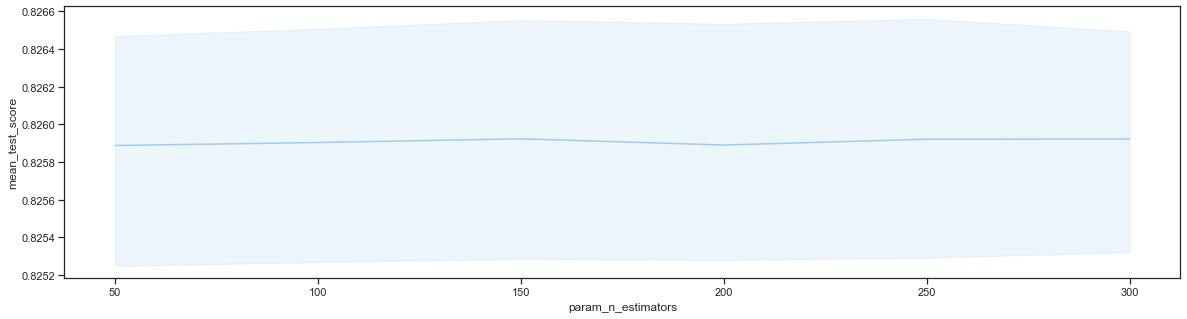

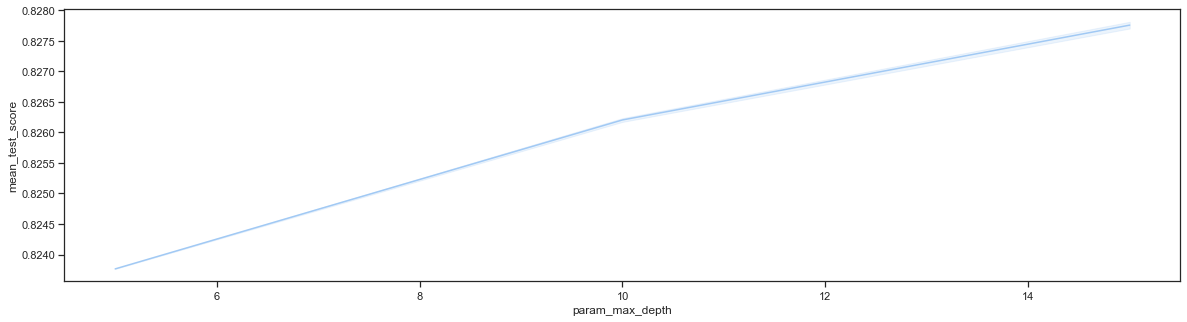

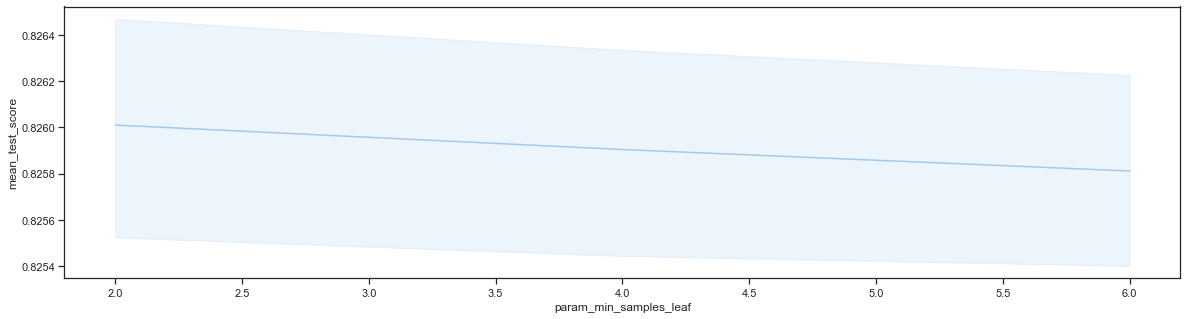

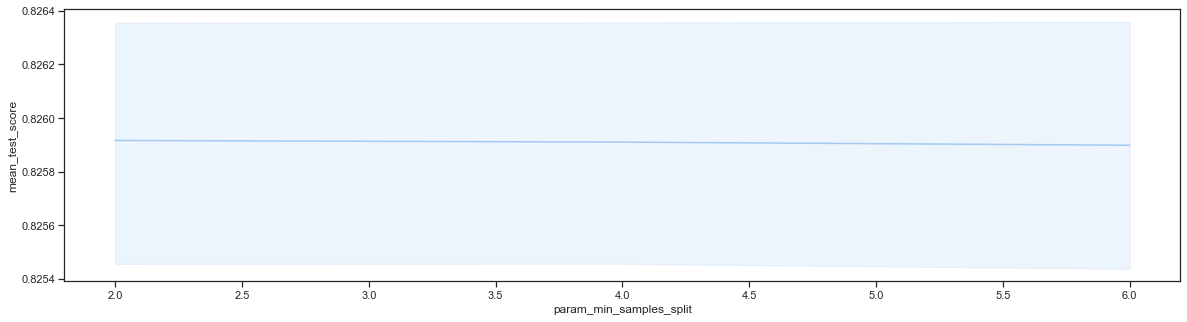

In [103]:
plt.figure(figsize=(20,5))
sns.lineplot (x=TestResults['param_n_estimators'], y=TestResults['mean_test_score'])

plt.figure(figsize=(20,5))
sns.lineplot (x=TestResults['param_max_depth'], y=TestResults['mean_test_score'])

plt.figure(figsize=(20,5))
sns.lineplot (x=TestResults['param_min_samples_leaf'], y=TestResults['mean_test_score'])

plt.figure(figsize=(20,5))
sns.lineplot (x=TestResults['param_min_samples_split'], y=TestResults['mean_test_score'])

##### Проведем повторный подбор параметров с учетом выявленных закономерностей, что результат практически не зависит от n_estimators,  min_samples_leaf, min_samples_split, но линейно увеличивается, при возрастании параметра  max_depth

In [107]:
# Определяем перечень параметров для тестирования
rfc = RandomForestClassifier()
parametrs = {'max_depth': range (5,50, 5)}

#Запуск
start=time.time()
grid_2nd = GridSearchCV(rfc, parametrs).fit(X_train, y_train)

print ("Подбор параметров произведен за ", time.time()-start, ' секунд.')

# Лучшие параметры для модели
grid_2nd.best_params_

Подбор параметров произведен за  909.5509779453278  секунд.


{'max_depth': 25}

In [109]:
TestResults2 = pd.DataFrame(grid_2nd.cv_results_)

<AxesSubplot:xlabel='param_max_depth', ylabel='mean_test_score'>

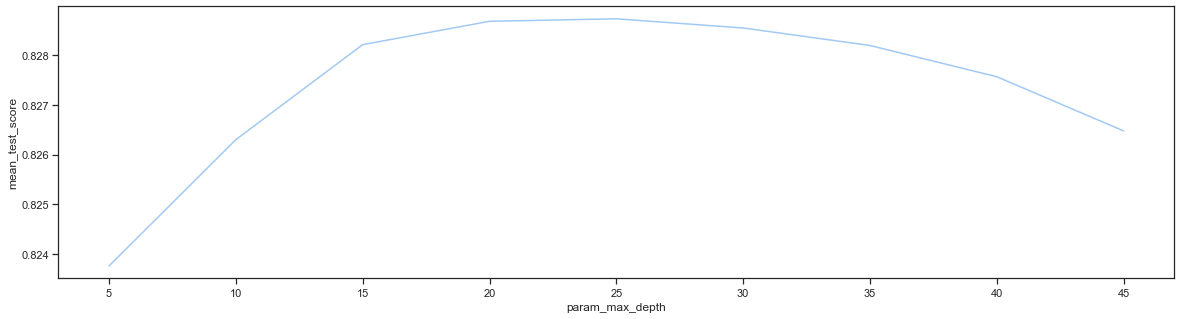

In [111]:
plt.figure(figsize=(20,5))
sns.lineplot (x=TestResults2['param_max_depth'], y=TestResults2['mean_test_score'])

###### Оценка с наиболее оптимальными параметрами: n_estimators = 100,  min_samples_leaf = 1, min_samples_split = 2, max_depth = 25

In [113]:
#### Оценка с лучшими параметрами:
grid_2nd.score (X_test, y_test)

0.8289473684210527

In [114]:
# AUC с лучшими параметрами
_pred = grid_2nd.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

0.757043589165828

##### RandomForest для данных ПОСЛЕ скалирования. Повторный подбор параметров не проводился из-за времязатратности.

In [115]:
rfc_scaled = RandomForestClassifier(max_depth=25) #стандартные параметры
rfc_scaled.fit(X_train_scaled,y_train)
rfc_scaled.score (X_test_scaled, y_test)

0.8288302358269561

In [116]:
y_pred_scaled = rfc_scaled.predict_proba(X_test_scaled)[:, 1]
roc_auc_score(y_test, y_pred_scaled)

0.7458150048785762

# ВЫВОДЫ:


1. Каких-либо сильных корелляций между исследуемыми параметрами не выявлено. Наибольшая 0.35 между уровнем зарплаты и суммой кредита.
2. Все переменные не соответствуют нормальному распределению.
3. Переменные monthly_income и credit_sum имеют достаточно выраженные выбросы. Однако при анализе, цифры не ошибочные. Просто это реалии России по зарплате )))
4. Наиболее оптимальной моделью из опробованных был RandomForestClassifier
5. При тестировании гиперпараметров выявлено, что n_estimators,  min_samples_leaf, min_samples_split мало влияют на точность предсказания, тогда как max_depth имеет достаточно сильное.
6. Проведеннй повторный тест показан, что оптимальное значение max_depth=25, при превышении его точность падает.
7. Скалирование не улучшает предсказание.
8. Наилучший результат AUC составил 0.757